# Importing necessary package

In [1]:
import pandas as pd 
import numpy as np

from scipy.stats import norm
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from __Function__ import *

np.random.seed(42)

# Importing Data

In [2]:
path = r'C:\Users\baris\Desktop\Master Thesis\1. Python\Data\Option_Calibration_SPX_18072025.csv'
df = pd.read_csv(path, index_col=None)   #Importing the Data for the Calibration
spx_price = 6296.79

# Convergence of Monte Carlo simulation to BS model

In [3]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def monte_carlo_price(S0, K, T, r, sigma, N):    
    Z = np.random.randn(N)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0)
    return np.exp(-r * T) * np.mean(payoff)

In [4]:
S0 = 100
sigma = 0.2
rate = 0.04
K = [80, 90, 100, 110, 120]
T = [0.2, 0.4, 0.6, 0.8, 1]
number_simulation = [int(1e3), int(1e4), int(1e5), int(1e6), int(1e7)]

store_value = []

for number in number_simulation:
    for strike in K:
        for maturity in T:
            np.random.seed(100)
            price_mc = monte_carlo_price(S0, strike, maturity, rate, sigma, number)
            price_bs = black_scholes_call(S0, strike, maturity, rate, sigma)
            store_value.append([number, strike, maturity, price_mc, price_bs])

In [5]:
convergence = pd.DataFrame(store_value, columns=['Number_Simulations', 'Strike', 'Maturity', 'Price_MC', 'Price_BS'])
convergence['Error'] = abs((convergence['Price_MC'] - convergence['Price_BS']) / convergence['Price_BS'])
mean_error = convergence.groupby('Number_Simulations')['Error'].mean().reset_index()

pivot = convergence[convergence['Number_Simulations']==convergence['Number_Simulations'].max()] #Filter for the max number_simulation
pivot_table = pivot.pivot(index='Strike', columns='Maturity', values='Error') #Create a pivot table to compare across different strike, different maturity

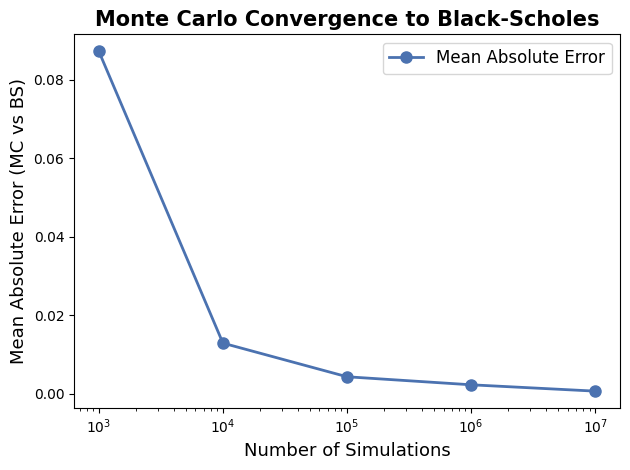

In [6]:
plt.plot(mean_error['Number_Simulations'], mean_error['Error'], marker='o', markersize=8, linewidth=2, color="#4B72B0", label='Mean Absolute Error')
plt.xscale('log')
plt.xlabel('Number of Simulations', fontsize=13)
plt.ylabel('Mean Absolute Error (MC vs BS)', fontsize=13)
plt.title('Monte Carlo Convergence to Black-Scholes', fontsize=15, fontweight='bold')
plt.legend(fontsize=12, loc="upper right", frameon=True, fancybox=True)
plt.grid(False)
plt.tight_layout()
plt.savefig(r"C:\Users\baris\Desktop\Master Thesis\2. Writing\BS\BS_convergence_curve.png", dpi=300, bbox_inches='tight')

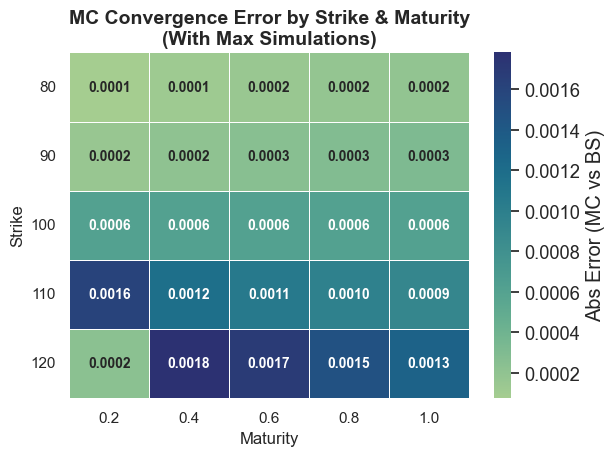

In [7]:
sns.set(style="whitegrid", font_scale=1.2)
sns.heatmap(pivot_table, annot=True, fmt=".4f", linewidths=0.7,
            cmap="crest", cbar_kws={"label": "Abs Error (MC vs BS)"}, 
            annot_kws={"size": 10, "weight": "bold"})

plt.title('MC Convergence Error by Strike & Maturity\n(With Max Simulations)', fontsize=14, fontweight='bold')
plt.xlabel('Maturity', fontsize=12)
plt.ylabel('Strike', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11, rotation=0)
plt.tight_layout()
plt.savefig(r"C:\Users\baris\Desktop\Master Thesis\2. Writing\BS\BS_convergence_heatmap.png", dpi=300, bbox_inches='tight')

# Calibration of the Monte Carlo under BS model 

In [8]:
S0 = 6296.79 # data from 18 july 2025
r = 0.0408   # data from 18 july 2025
T = df['Maturity'].to_numpy('float')
market_prices = df['Price'].to_numpy('float')
strikes = df['Strike'].to_numpy('float')

In [9]:
def loss_function(x, lam=0.1):
    losses = []
    sigma = x

    for maturity, strike, price in zip(T, strikes, market_prices):
        mc_prices = black_scholes_call(S0, strike, maturity, r, sigma)
        losses.append(np.sum((mc_prices - price)**2) + lam * sigma**2)  #lam to penalize extreme value of sigma
        
    return sum(losses)

In [10]:
result = minimize(
    loss_function,
    x0=np.array([0.2]),
    method='L-BFGS-B',
    bounds=[(1e-2, 0.5)],
    options={'maxiter': 1e6, 'ftol': 1e-6})

result

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 35985.50954587509
        x: [ 1.470e-01]
      nit: 4
      jac: [ 1.516e+00]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [11]:
calibrated_sigma = result.x[0] #Extract the calibrated sigma
calibrated_sigma

np.float64(0.14699995495014173)

In [12]:
df['BS_Calibrated'] = [black_scholes_call(spx_price, strike, maturity, r, calibrated_sigma) for strike, maturity in zip(strikes, T)] #Price with the BS model for all strike and maturity 
df['Error'] = abs((df['BS_Calibrated'] - df['Price'])) #Calculate the absolute error

In [13]:
df['Error'].mean(), df['Error'].median()

(np.float64(18.199378285361643), np.float64(17.889559026621146))

# Summary of the Monte Carlo Calibration under BS 

In [14]:
# Import the full data to compare how good is our calibrated BS model
path = r'C:\Users\baris\Desktop\Master Thesis\1. Python\Data\Option_Data_SPX_18072025.csv'
df_pricing = pd.read_csv(path, index_col=None)[['Maturity', 'Strike', 'Price']]

strikes_pricing = df_pricing['Strike'].to_numpy('float')
maturity_pricing = df_pricing['Maturity'].to_numpy('float')

df_pricing['BS_Calibrated'] = [black_scholes_call(spx_price, strike, maturity, r, calibrated_sigma) for strike, maturity in zip(strikes_pricing, maturity_pricing)] #Price with the BS model for all strike and maturity 
df_pricing['Error'] = abs((df_pricing['BS_Calibrated'] - df_pricing['Price'])) #Calculate the absolute error

In [15]:
df_pricing['Error'].mean(), df_pricing['Error'].median() 

(np.float64(18.173922855403312), np.float64(17.703161692213996))

In [16]:
maturity_error = Comparaison.comparaison_maturity(df_pricing)
maturity_error

,Metric Maturity,Mean Eror (abs)
0,"Mean (Filtered for maturity < 0.3, Price = 143...",14.1701
1,"Mean (Filtered for maturity >= 0.3 and < 0.6, ...",19.6949
2,"Mean (Filtered for maturity >= 0.6, Price = 35...",23.5197


In [17]:
strike_error = Comparaison.comparaison_strike(df_pricing, spx_price)
strike_error

,Metric Strike,Mean Eror (abs)
0,"Mean (Filtered for strike < 100, Price = 357.6...",19.3907
1,"Mean (Filtered for strike >= 100 and < 105, Pr...",12.3856
2,"Mean (Filtered for strike >= 105, Price = 75.9...",24.5741


In [18]:
surface_error = Comparaison.comparaison_surface(df_pricing)
surface_error 

,Metric Surface,Mean Eror (abs)
0,"Mean (Filtered for price < 81.70$, 20% Quantile)",21.3337
1,"Mean (Filtered for price > 81.70$, 20% Quantile)",17.3396
2,"Mean (Filtered for price > 214.65$, 50% Quantile)",17.5303
3,"Mean (Filtered for price > 370.98$, 80% Quantile)",27.7857
4,Mean,18.1739
5,Median,17.7032


In [19]:
Comparaison.saving_data(maturity_error, 'BS\BS_maturity_error')
Comparaison.saving_data(strike_error, 'BS\BS_strike_error')
Comparaison.saving_data(surface_error, 'BS\BS_surface_error')